<a href="https://colab.research.google.com/github/bloomfieldfong/Stadistical-Learning/blob/main/Tarea4Fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [222]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [7]:
fashion_mnist = keras.datasets.fashion_mnist

In [8]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

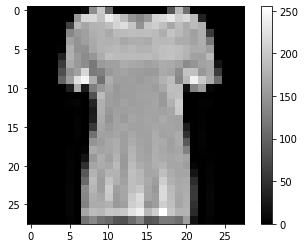

In [47]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [48]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

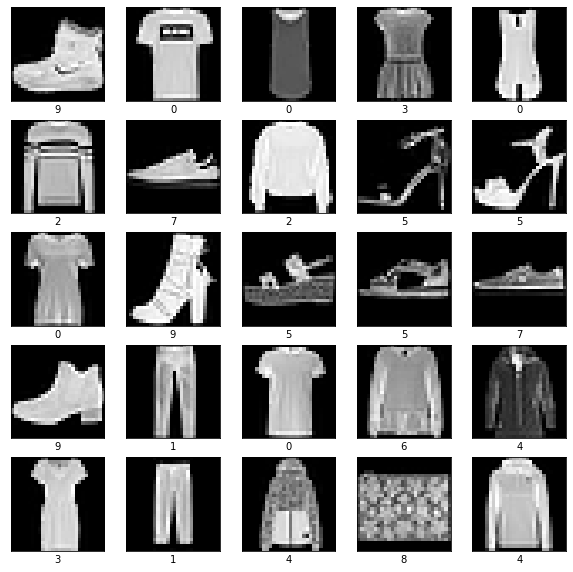

In [49]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

Selección de variables a predecir

In [221]:
#Selecciona los que son camisas (1)
tshirts1 = train_labels == 1
#Selecciona los que son tacones (5)
heals5 = train_labels == 5
#Selecciona los que son zapatos (9)
shoes9 = train_labels == 4
#Or de todos los demas y nos da una lista de cuales son parte de estos 3 y cuales no 
seleccionados = tshirts1 | heals5  | shoes9
#Obtener las imagenes de entrenamiento
entrenamientoy = train_labels[seleccionados]

#Cambio de variables 1, 5 y 4 a 0, 1, 2
entrenamientoy[entrenamientoy == 1] = 0
entrenamientoy[entrenamientoy == 5] = 1
entrenamientoy[entrenamientoy == 4] = 2 

#Reshape de las imagenes
entrenamientox = np.reshape(train_images, (train_images.shape[0], 28*28))
entrenamientox = entrenamientox[seleccionados]

Diccionario de nombres

In [197]:
# Diccionario de nombre de prediccion
clases = {0 : "T-shirt", 1 : "Heals", 2 : "Sweather"}

Modelo de regresion logisitca Softmax

In [217]:
def modelo_regresion_logistica(x, y, epochs, mini_batch, learningRate, imprimir_error_cada):
    tf.reset_default_graph()
    grafo = tf.Graph()
    with grafo.as_default():
      sess = tf.Session() 
      #tamaño de la data de entrenamiento
      N, K = x.shape
      # X
      X = tf.placeholder(tf.float32, shape = [N, K], name = "X")
      #Learning rate
      lr = tf.placeholder(tf.float32, name = "LearningRate")
      #Y 
      Y = tf.placeholder(tf.int32, name = "Y")
      #variable de peso normalizado
      peso = tf.Variable(tf.truncated_normal(shape = [K, 3]), name = "weight")
        
      with tf.name_scope("costo"):
          #Logits
          logits = tf.matmul(X, peso, name = "logits") 
          #Ysombrero
          ysombrero = tf.nn.softmax(logits, name = "ysombrero")
          #calculo de costo
          costo = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = Y, logits = logits), name = "costo")

      #Calculo de gradiente
      with tf.name_scope("gradiente"):
          graddescoptimizer = tf.train.GradientDescentOptimizer(lr).minimize(costo) 
              
      #Calculo de exactitud
      with tf.name_scope("exactitud"):
          correctPredictions = tf.equal(Y, tf.argmax(ysombrero, 1, output_type = tf.int32), name = "Prediccion_Correcta")
          exactitud = tf.reduce_mean(tf.cast(correctPredictions, tf.float32), name = "exactitud")

      #Calculo de resumen de exactitud y costo
      with tf.name_scope("resumen"):
        cost_summary = tf.summary.scalar(name='costo', tensor = costo)
        exactitud_summary = tf.summary.scalar(name='exactitud', tensor = exactitud)
        summaries = tf.summary.merge_all()
        init = tf.global_variables_initializer()
            
      with tf.name_scope("prediccion"):
        sess.run(init)
        for epoch in range(epochs):
          _, prediction = sess.run([graddescoptimizer, summaries], feed_dict = {X : x, Y : y, lr : learningRate})
          if ((epoch+1) % imprimir_error_cada) == 0:
            c = sess.run(costo, feed_dict = {X : x, Y : y})
            print("Epoch = %d Batch = %d Costo: %0.4f" % (epoch+1, 32, c))
            pesos = sess.run(peso)
    return pesos

#                                  (x, y, epochs, mini_batch, lr, imprimir_error_cada
prueba = modelo_regresion_logistica(entrenamientox, entrenamientoy, 100, 10, 0.1, 10)


Epoch = 10 Batch = 32 Costo: 1611.5951
Epoch = 20 Batch = 32 Costo: 741.4172
Epoch = 30 Batch = 32 Costo: 340.2021
Epoch = 40 Batch = 32 Costo: 225.3985
Epoch = 50 Batch = 32 Costo: 183.5216
Epoch = 60 Batch = 32 Costo: 163.1413
Epoch = 70 Batch = 32 Costo: 149.3973
Epoch = 80 Batch = 32 Costo: 138.4569
Epoch = 90 Batch = 32 Costo: 129.2614
Epoch = 100 Batch = 32 Costo: 121.0947


Funcion de predicción

In [199]:
def predecir(variable, peso):
  logits = np.matmul(variable, peso)
  y = np.argmax(logits)
  respuesta = clases[y]
  return respuesta

Variables de prueba para: "Heals", "T-shirts" y "Sweather"

In [200]:
#Selecciona los que son camisas (1)
tshirts1 = test_labels == 1
#Selecciona los que son tacones (5)
heals5 = test_labels == 5
#Selecciona los que son zapatos (9)
shoes9 = test_labels == 4
#Or de todos los demas y nos da una lista de cuales son parte de estos 3 y cuales no 
seleccionados = tshirts1 | heals5  | shoes9
#Obtener las imagenes de entrenamiento
testy = test_labels[seleccionados]

testy[testy == 1] = 0
testy[testy == 5] = 1
testy[testy == 4] = 2 

testx = np.reshape(test_images, (test_images.shape[0], 28*28))
testx = testx[seleccionados]

testxN, testxK = testx.shape

Seleccion de pruebas aleatorias

In [224]:
pruebas_aleatorias = np.random.randint(0, testxN, 5)
print(pruebas_aleatorias)

imagenes_prueba = testx[pruebas_aleatorias]
print(imagenes_prueba)

[2214 2151 1018 1866 2280]
[[ 0  0  0 ... 60  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


Pruebas aleatorias 

Imangen: 2214


Text(0.5, 0, 'Heals')

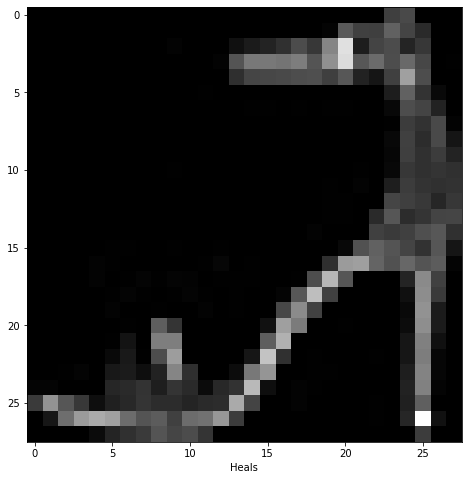

In [225]:
print("Imangen: "+str(pruebas_aleatorias[0]))
plt.figure(figsize = (8,8))
imagen = imagenes_prueba[0].reshape((28,28))
plt.imshow(imagen, cmap = 'gray')
plt.xlabel(predecir(imagenes_prueba[0], prueba))

Imangen: 2362


Text(0.5, 0, 'Sweather')

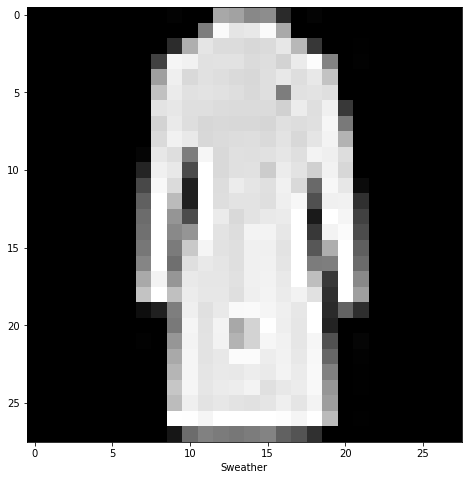

In [205]:
print("Imangen: "+str(pruebas_aleatorias[1]))
plt.figure(figsize = (8,8))
imagen = imagenes_prueba[1].reshape((28,28))
plt.imshow(imagen, cmap = 'gray')
plt.xlabel(predecir(imagenes_prueba[1], prueba))

Imangen: 1207


Text(0.5, 0, 'Heals')

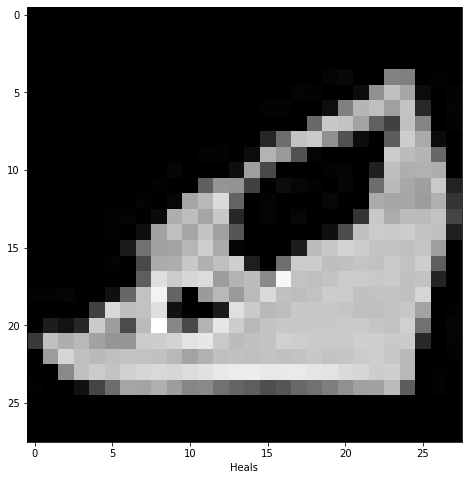

In [206]:
print("Imangen: "+str(pruebas_aleatorias[3]))
plt.figure(figsize = (8,8))
imagen = imagenes_prueba[3].reshape((28,28))
plt.imshow(imagen, cmap = 'gray')
plt.xlabel(predecir(imagenes_prueba[3], prueba))

Imangen: 1847


Text(0.5, 0, 'Sweather')

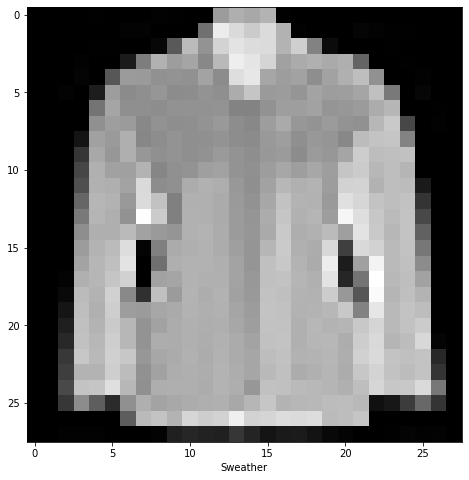

In [210]:
print("Imangen: "+str(pruebas_aleatorias[4]))
plt.figure(figsize = (8,8))
imagen = imagenes_prueba[4].reshape((28,28))
plt.imshow(imagen, cmap = 'gray')
plt.xlabel(predecir(imagenes_prueba[4], prueba))

Imangen: 2280


Text(0.5, 0, 'Heals')

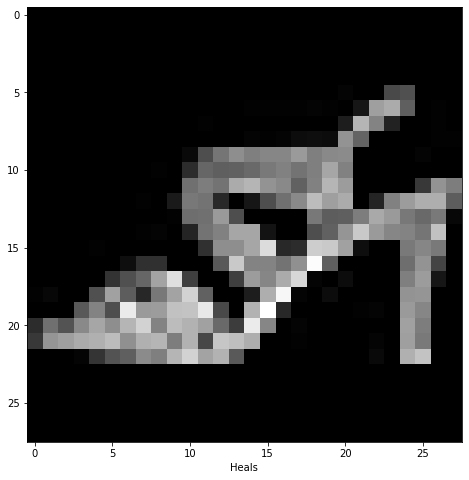

In [226]:
print("Imangen: "+str(pruebas_aleatorias[4]))
plt.figure(figsize = (8,8))
imagen = imagenes_prueba[4].reshape((28,28))
plt.imshow(imagen, cmap = 'gray')
plt.xlabel(predecir(imagenes_prueba[4], prueba))